In [1]:
# !pip install yfinance
# !pip install fredapi

In [2]:
!git clone https://github.com/Inwest1997/TradingSystem.git

fatal: destination path 'TradingSystem' already exists and is not an empty directory.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler

In [2]:
from TradingSystem.src.index import *
from TradingSystem.src.backtesting import *

In [4]:
class TFDataset(keras.utils.Sequence):
    """
    Custom data generator class for Digits dataset
    """
    def __init__(self, 
                 ticker,
                 window = 14,
                 period = 1,
                 target = 'adjClose',
                 scaling = False, 
                 target_gen = None, 
                 drop_feature = None, 
                 batch_size: int=64,
                 mode = 'train', 
                 split = 0.8):
        self.ticker = ticker
        df = yf.Ticker(self.ticker).history(period="max", interval = '1d', auto_adjust = False)[['Open','High','Low','Adj Close','Volume']]
        df.columns = ['open','high','low','adjClose','volume']
        df.reset_index(inplace=True)
        df['Date'] = df['Date'].dt.strftime('%Y/%m/%d')
        df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
        df.set_index('Date', inplace = True)
        self.df = df
        l = len(self.df)
        self.target = target
        if mode == 'train':
            self.df = self.df.iloc[:int(split * l)]
        elif mode == 'test':
            self.df = self.df.iloc[int(split * l):]
        self.df = read_all(self.df)
        if drop_feature != None:
            self.df.drop(drop_feature, axis = 1)
        self.df = self.df.dropna(axis = 0)
        self.X, self.y = self.df, self.df[[self.target]]
        self.target_generator(target_gen)
        if scaling == True:
            self.scaler()
        self.columns = self.df.columns
        self.period = (self.df.index.max()-self.df.index.min()).days
        self.batch_size = batch_size
        self.X, self.y = self.my_window_data(window_size = window, for_period=period)

    def my_window_data(self, window_size, for_period):
        X_list = [self.X.iloc[i:i+window_size] for i in range(len(self.X) - window_size-for_period)]
        y_list = [self.y[self.target].iloc[i+window_size:i+window_size+for_period].values for i in range(len(self.y) - window_size-for_period)]
        return  np.array(X_list), np.array(y_list)

    def scaler(self):
        scaler = MinMaxScaler()
        self.X = pd.DataFrame(columns = self.X.columns, data = scaler.fit_transform(self.X))
        self.y = pd.DataFrame(columns = self.X.columns, data = np.log1p(self.y))

    def target_generator(self, target_gen):

        if target_gen == None:
            pass
        elif target_gen == 'trend':
            self.y[self.target] = ['up' if self.y[self.target].diff().iloc[i]>0 else 'down' for i in range(len(self.y[self.target]))]
            self.y = pd.get_dummies(self.y[self.target])
            # self.y = tf.keras.utils.to_categorical(self.y[self.target],  num_classes=2)

        else:
            self.y[self.target] = [  'buy' if self.y[self.target].diff(1).iloc[i]>0 and self.y[self.target].diff(-1).iloc[i]>0
                                else 'sell' if self.y[self.target].diff(1).iloc[i]<0 and self.y[self.target].diff(-1).iloc[i]<0
                                else 'hold' for i in range(len(self.y[self.target]))]
            self.y = pd.get_dummies(self.y[self.target])
            
    def __len__(self):
        return np.math.ceil(len(self.X) / self.batch_size)
    
    def __getitem__(self, index):
        """
        Returns a batch of data
        """
        batch_X = self.X[index * self.batch_size : (index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size : (index + 1) * self.batch_size]

        return batch_X, batch_y
    def only_data(self):
        return self.X, self.y

In [5]:
X_train, y_train = TFDataset(ticker='AAPL', scaling = True, mode= 'train').only_data()
X_test,  y_test  = TFDataset(ticker='AAPL', scaling = True, mode= 'test').only_data()

(6116, 21)
(2048, 21)


In [6]:
X_train.shape, y_train.shape

((6101, 14, 21), (6101, 1))

In [7]:
X_test.shape, y_test.shape

((2033, 14, 21), (2033, 1))

In [8]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [9]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [10]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="MSE",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["MSE", "MAE"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=20,
    callbacks=callbacks,
)

model.evaluate(X_test, y_test, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14, 21)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 14, 21)      42          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 14, 21)      89109       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

[7.056790351867676, 7.056790351867676, 2.631563901901245]

In [11]:
y_pred = model.predict(X_test)

64/64 [==============================] - 1s 5ms/step


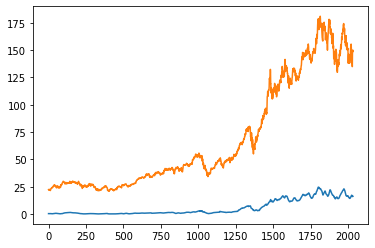

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.expm1(y_pred))
plt.plot(np.expm1(y_test))

In [ ]:
len(y_test)

In [13]:
forecast = pd.DataFrame({'forecast':y_pred.reshape(-1),'actual':y_test.reshape(-1)}, index = range(len(y_test)))

In [14]:
forecast['a_position'] = [  'buy' if forecast['actual'].diff(1).iloc[i]>0 and forecast['actual'].diff(-1).iloc[i]>0
                                else 'sell' if forecast['actual'].diff(1).iloc[i]<0 and forecast['actual'].diff(-1).iloc[i]<0
                                else 'hold' for i in range(len(forecast['actual']))]

In [15]:
forecast['a_trend'] = ['up' if forecast['actual'].diff().iloc[i]>0 else 'down' for i in range(len(forecast))]

In [16]:
forecast['f_position'] = [  'buy' if forecast['forecast'].diff(1).iloc[i]>0 and forecast['forecast'].diff(-1).iloc[i]>0
                                else 'sell' if forecast['forecast'].diff(1).iloc[i]<0 and forecast['forecast'].diff(-1).iloc[i]<0
                                else 'hold' for i in range(len(forecast['forecast']))]

In [17]:
forecast['f_trend'] = ['up' if forecast['forecast'].diff().iloc[i]>0 else 'down' for i in range(len(forecast))]

In [18]:
forecast['position_match'] = [1 if forecast['a_position'].iloc[i]==forecast['f_position'].iloc[i]  else 0 for i in range(len(forecast['forecast']))]

In [19]:
forecast['position_match'].sum()/len(forecast)

0.44072798819478604

In [20]:
forecast['trend_match'] = [1 if forecast['a_trend'].iloc[i]==forecast['f_trend'].iloc[i]  else 0 for i in range(len(forecast['forecast']))]

In [21]:
forecast['trend_match'].sum()/len(forecast)

0.5194294146581406

lag1

In [22]:
forecast['f_position_lag1'] = forecast['f_position'].shift(-1)

In [23]:
forecast['position_lag1_match'] = [1 if forecast['a_position'].iloc[i]==forecast['f_position_lag1'].iloc[i]  else 0 for i in range(len(forecast['forecast']))]

In [24]:
forecast['position_lag1_match'].sum()/len(forecast)

0.47614363010329563

In [25]:
forecast['f_position_lag2'] = forecast['f_position'].shift(-2)

In [26]:
forecast['position_lag2_match'] = [1 if forecast['a_position'].iloc[i]==forecast['f_position_lag2'].iloc[i]  else 0 for i in range(len(forecast['forecast']))]

In [27]:
forecast['position_lag2_match'].sum()/len(forecast)

0.4525332021642892

In [28]:
forecast['f_position_lag3'] = forecast['f_position'].shift(-3)

In [29]:
forecast['position_lag3_match'] = [1 if forecast['a_position'].iloc[i]==forecast['f_position_lag3'].iloc[i]  else 0 for i in range(len(forecast['forecast']))]

In [30]:
forecast['position_lag3_match'].sum()/len(forecast)

0.4677816035415642

In [32]:
df = TFDataset(ticker='AAPL', scaling = True, mode = 'test').df
df.reset_index(inplace = True)

(2048, 21)


In [33]:
df

,Date,open,high,low,adjClose,volume,RSI,macd,macd_signal,macd_oscillator,...,en_lb,slow_k,slow_d,cci,T10Y2Y,VIX,OBV,OBV_mv20,SMA(5),SMA(10)
0,2014-09-09,24.770000,25.770000,24.035000,21.956087,759385200,46.236131,0.12,0.23,-0.11,...,20.633877,-141.36,-109.42,-57.036649,1.94,13.50,503718400,9.569421e+08,22.064986,22.483761
1,2014-09-10,24.502501,25.277500,24.440001,22.630524,403478400,58.171239,0.14,0.21,-0.07,...,20.670191,-115.09,-73.92,-63.945642,1.96,12.88,907196800,1.015823e+09,22.157299,22.486226
2,2014-09-11,25.102501,25.360001,24.905001,22.726871,249412400,59.552614,0.16,0.20,-0.04,...,20.705836,-84.06,-68.85,7.230242,1.96,12.80,1156609200,1.080792e+09,22.305630,22.470542
3,2014-09-12,25.302500,25.547501,25.270000,22.778410,250504400,60.307736,0.17,0.20,-0.03,...,20.742630,-69.64,-66.14,59.110840,2.04,13.31,1407113600,1.152662e+09,22.426177,22.457322
4,2014-09-15,25.702499,25.762501,25.360001,22.771683,245266000,60.149884,0.19,0.20,-0.01,...,20.776966,-67.16,-66.49,100.579367,2.02,14.12,1161847600,1.202479e+09,22.572715,22.437829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2022-11-10,141.240005,146.869995,139.500000,146.869995,118854000,52.078579,-1.82,-1.42,-0.40,...,140.226759,26.10,54.02,-13.035315,-0.52,23.53,5149714600,5.219031e+09,139.707999,144.094844
2044,2022-11-14,148.970001,150.279999,147.429993,148.279999,73374100,53.149289,-0.71,-1.23,0.52,...,139.936622,60.13,60.12,74.563595,-0.52,23.73,5170244300,5.229784e+09,143.843997,143.036031
2045,2022-11-15,152.220001,153.589996,148.559998,150.039993,89868300,54.909728,-0.23,-1.03,0.80,...,139.856174,64.70,67.73,87.546979,-0.57,24.54,5260112600,5.230731e+09,145.951996,142.999980
2046,2022-11-16,149.130005,149.869995,147.289993,148.789993,64218300,53.375705,0.05,-0.82,0.87,...,139.724851,63.39,62.33,54.624157,-0.68,24.11,5195894300,5.225379e+09,148.735995,143.399998


In [34]:
position_dict = {'hold':0, 'buy':1, 'sell':2}

In [35]:
a_position = [0 if forecast['a_position'].iloc[i]=='hold' else 1 if forecast['a_position'].iloc[i]=='buy' else 2 for i in range(len(forecast))]

In [39]:
len(a_position)

2033

In [42]:
y_test.shape[0]+y_train.shape[0]

8134

In [38]:
BacktestBase(df ,pd.DataFrame(a_position, index = df.index), result_show =True)

ValueError: ignored